In [2]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [4]:
from pyaldata import *

In [5]:
date = '0504'

In [6]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [7]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [8]:
data_path = './Data/Processed_Data/Tidy_Sansa_0504Clean.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [9]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [10]:
tonic_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [11]:
stim_df = tidy_df.loc[tidy_df.type == 'BC-REACH'].reset_index()

In [12]:
class CausalTemporalLSTM(nn.Module):
    def __init__(self, num_features=124, 
                    hidden_units= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    input_size = 50,
                    out_dims = 6, 
                    dropout_1 = 0.3, 
                    dropout_2 = 0.3):
        super(CausalTemporalLSTM, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_size = input_size

        self.lstm = nn.LSTM(
            input_size= self.input_size,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,)
            
        self.linear1 = nn.Linear(in_features=self.num_features, out_features= self.input_size)
        self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=out_dims)


        self.dropout1 = nn.Dropout(p= dropout_1) #trial.suggest_float('dropout_1', 0.1, 0.9)
        self.dropout2 = nn.Dropout(p= dropout_2) 

    def forward(self, x):

        x = self.linear1(x)
        x = self.dropout1(x)
        x, _ = self.lstm(x)
        x = self.dropout2(x)
        output = self.linear2(x)
        # Apply sigmoid activation function
        output = torch.sigmoid(output) # (torch.sigmoid(output) *600 ) - 200
        
        return output.squeeze()

## Get train-val-test split

In [14]:
fold = 0

In [15]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, info_train_base, info_val_base, info_test_base, list_mins_base, list_maxs_base= get_dataset(baseline_df, fold, no_outliers = False)

Test trials  6
Val trials 4
We are testing the optimization method on fold  0


In [16]:
xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, info_train_stim, info_val_stim, info_test_stim,  list_mins_stim, list_maxs_stim = get_dataset(tonic_df, fold, no_outliers = False)

Test trials  7
Val trials 6
We are testing the optimization method on fold  0


In [17]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, info_train_all, info_val_all, info_test_all,  list_mins_all, list_maxs_all = get_dataset(tidy_df,fold, no_outliers = False)

Test trials  26
Val trials 21
We are testing the optimization method on fold  0


In [18]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [19]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

## Baseline Model

In [20]:
''' Hyper Baseline'''

# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5

l1_ratio_reg = 0.5

lr = 0.0001# 0.0002
loss_function = huber_loss
huber_delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 32
num_layers = 3
input_size_LSTM = 31
dropout_1 = 0.2
dropout_2 = 0.2

#Other training hyperparameters

lr_gamma= 0.9 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25

In [21]:
# Fit the LSTM model
model_base = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

model_base.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [22]:
train_losses, val_losses = \
    train_model(model_base, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 7)


Epoch 000 Train 0.0283 Val 0.0265
Epoch 001 Train 0.0265 Val 0.0248
Epoch 002 Train 0.0238 Val 0.0222
Epoch 003 Train 0.0204 Val 0.0197
Epoch 004 Train 0.0172 Val 0.0167
Epoch 005 Train 0.0140 Val 0.0146
Epoch 006 Train 0.0120 Val 0.0137
Epoch 007 Train 0.0110 Val 0.0131
Epoch 008 Train 0.0102 Val 0.0126
Epoch 009 Train 0.0097 Val 0.0121
Epoch 010 Train 0.0092 Val 0.0117
Epoch 011 Train 0.0089 Val 0.0114
Epoch 012 Train 0.0086 Val 0.0110
Epoch 013 Train 0.0083 Val 0.0108
Epoch 014 Train 0.0079 Val 0.0105
Epoch 015 Train 0.0077 Val 0.0103
Epoch 016 Train 0.0075 Val 0.0101
Epoch 017 Train 0.0073 Val 0.0099
Epoch 018 Train 0.0071 Val 0.0097
Epoch 019 Train 0.0069 Val 0.0096
Epoch 020 Train 0.0067 Val 0.0095
Epoch 021 Train 0.0065 Val 0.0094
Epoch 022 Train 0.0064 Val 0.0093
Epoch 023 Train 0.0062 Val 0.0092
Epoch 024 Train 0.0061 Val 0.0091
Epoch 025 Train 0.0060 Val 0.0092
Epoch 026 Train 0.0058 Val 0.0091
Epoch 027 Train 0.0058 Val 0.0091
Epoch 028 Train 0.0056 Val 0.0091
Epoch 029 Trai

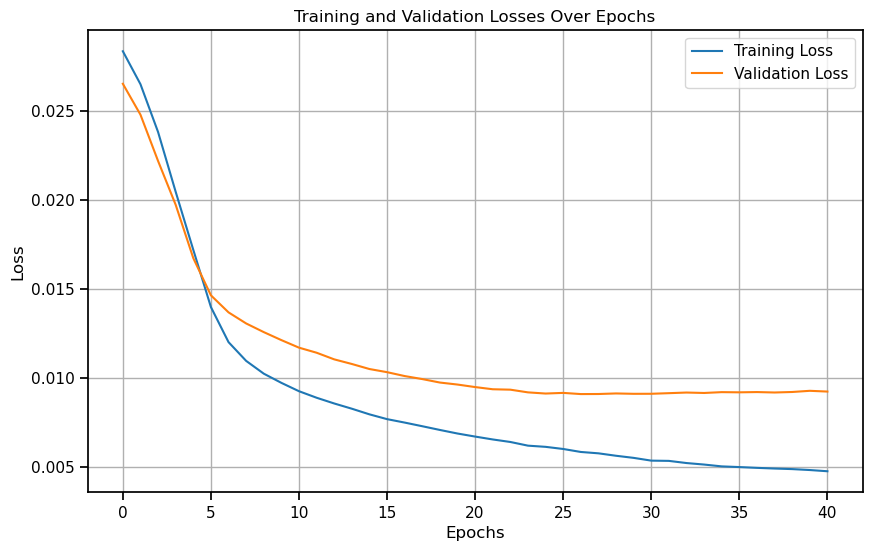

In [23]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [24]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_base, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [25]:
model_baselineonly = torch.load(path_to_save_model_fold)
model_baselineonly.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [26]:
def reshape_to_eval(x,y, model):
    # Convert X_train and y_train to PyTorch tensors
    inputs = torch.tensor(x, device=device, dtype=torch.float32)
    targets = torch.tensor(y, device=device, dtype=torch.float32)

    y_pred = model(inputs)
    y_array = targets.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D



def eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'rmse'):

    #Move tensors to cpu and reshape them for evaluation
    y_true_train, y_pred_train = reshape_to_eval(xx_train,yy_train, model)
    y_true_val, y_pred_val = reshape_to_eval(xx_val,yy_val, model)
    y_true_test, y_pred_test = reshape_to_eval(xx_test,yy_test, model)

    if metric == 'rmse':
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
        print('Train Score: %.2f RMSE' % (trainScore))
        valScore = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
        print('Val Score: %.2f RMSE' % (valScore))
        testScore = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
        print('Test Score: %.2f RMSE' % (testScore))

        return y_pred_val, y_true_val,trainScore, valScore, testScore
    
    elif metric == 'ev':
        #Compute explained variance
        ev_train = explained_variance_score(y_true_train, y_pred_train)
        ev_val = explained_variance_score(y_true_val, y_pred_val)
        ev_test = explained_variance_score(y_true_test, y_pred_test)
        print('Train EV: %.2f ' % (ev_train))
        print('Val EV: %.2f ' % (ev_val))
        print('Test EV: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test
    
    elif metric == 'r2':
        #Compute explained variance
        ev_train = r2_score(y_true_train, y_pred_train)
        ev_val = r2_score(y_true_val, y_pred_val)
        ev_test = r2_score(y_true_test, y_pred_test)
        print('Train R2: %.2f ' % (ev_train))
        print('Val R2: %.2f ' % (ev_val))
        print('Test R2: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test

In [27]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_baselineonly, metric = 'ev')

Train EV: 0.78 
Val EV: 0.67 
Test EV: 0.01 


In [28]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_baselineonly, metric = 'r2')

Train R2: 0.78 
Val R2: 0.65 
Test R2: -62.94 


In [29]:
y_true_train, y_pred_train = reshape_to_eval(xx_train_base,yy_train_base, model_baselineonly)

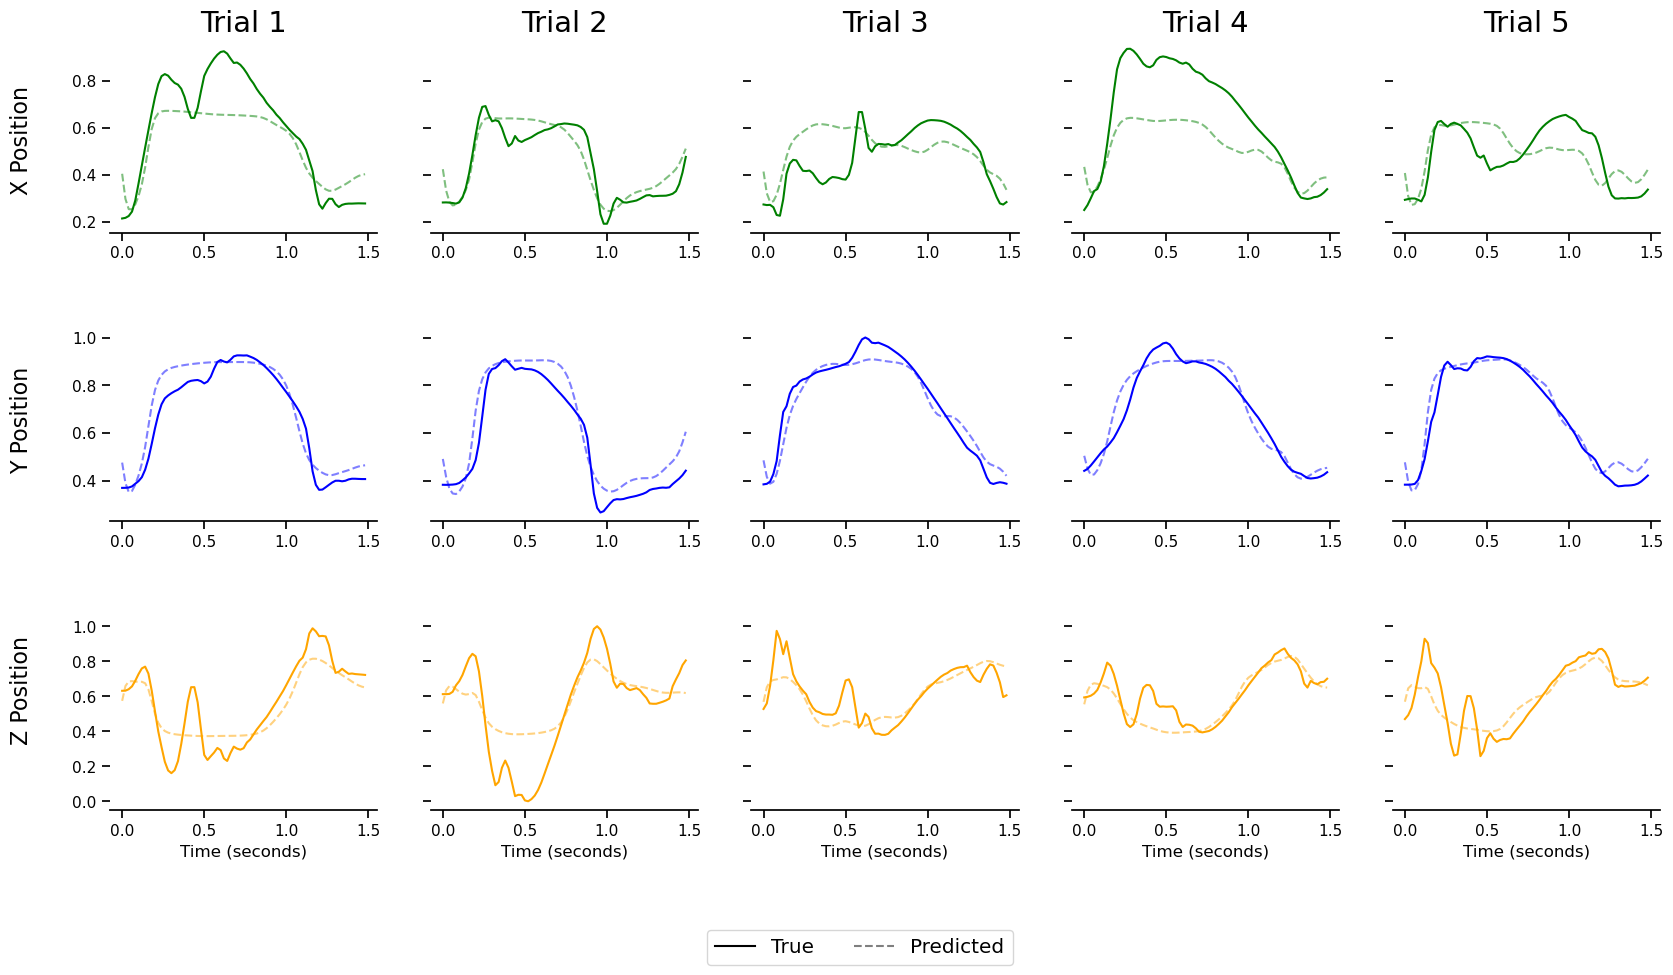

In [30]:
visualize_LSTM_test(y_pred_train, y_true_train, seq_length = 75)

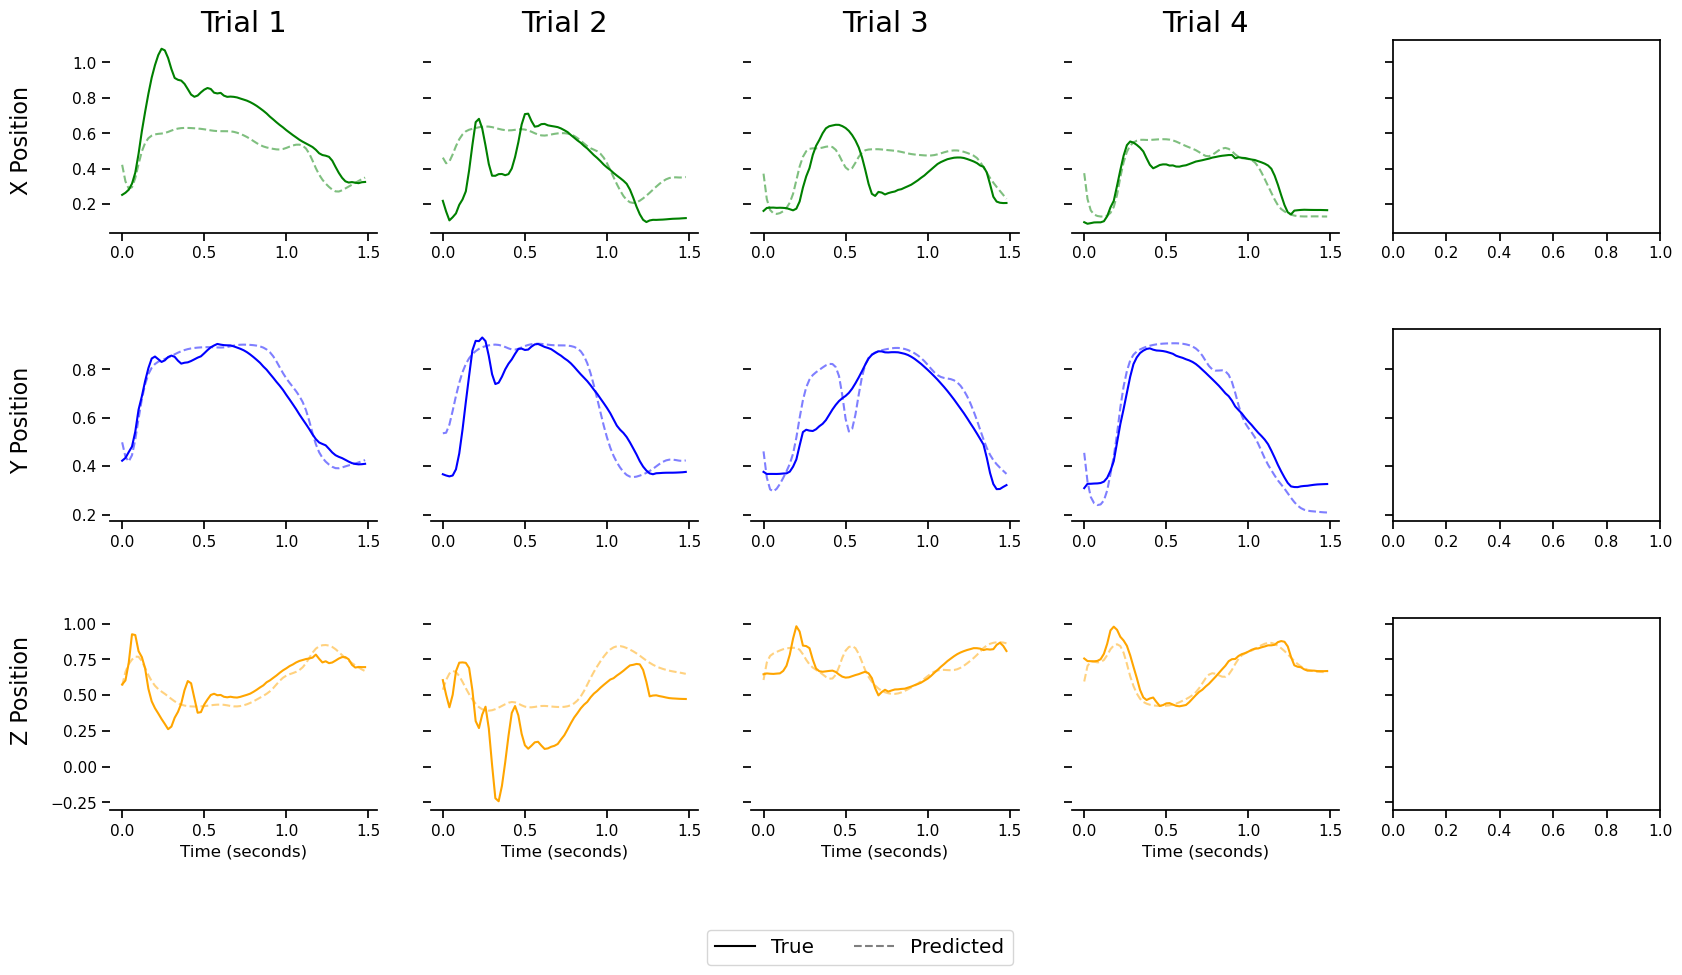

In [31]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Testing the model on stimulation data

In [32]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_baselineonly, metric = 'ev')

Train EV: 0.59 
Val EV: 0.55 
Test EV: 0.01 


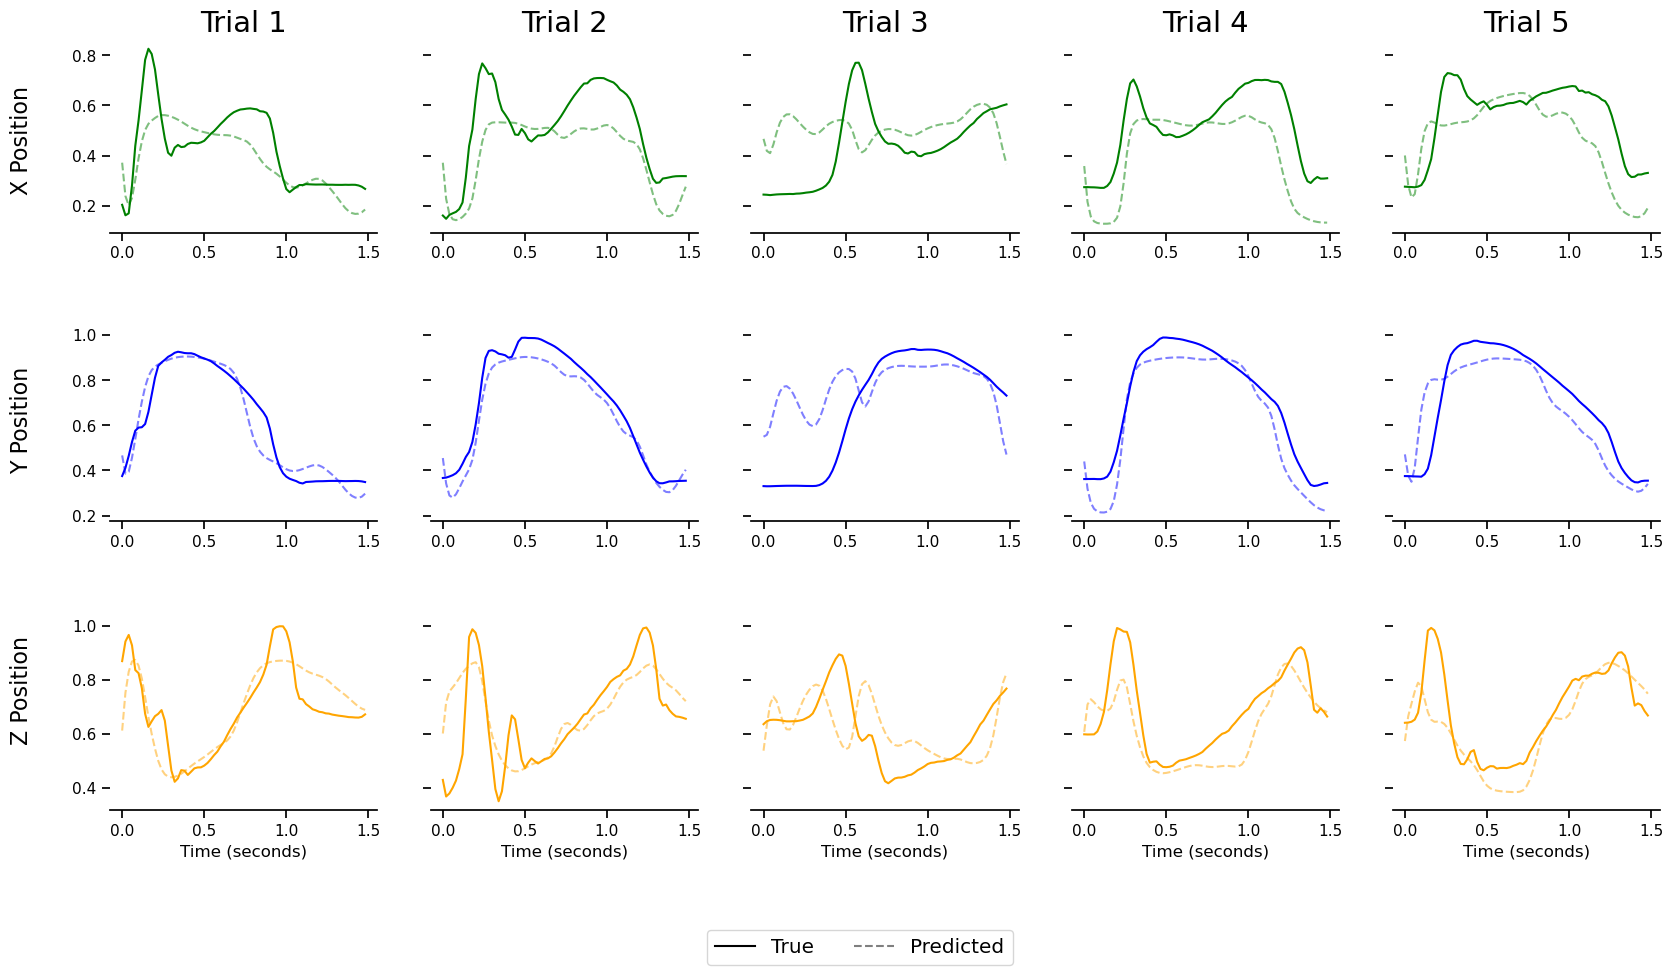

In [33]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Now we use all data for training

In [34]:
# Fit the LSTM model
model_all = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_all.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [35]:
train_losses, val_losses = \
    train_model(model_all, xx_train_all,yy_train_all,
                xx_val_all, 
                yy_val_all,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0246 Val 0.0143
Epoch 001 Train 0.0120 Val 0.0081
Epoch 002 Train 0.0077 Val 0.0058
Epoch 003 Train 0.0061 Val 0.0048
Epoch 004 Train 0.0053 Val 0.0042
Epoch 005 Train 0.0047 Val 0.0038
Epoch 006 Train 0.0043 Val 0.0035
Epoch 007 Train 0.0040 Val 0.0033
Epoch 008 Train 0.0037 Val 0.0032
Epoch 009 Train 0.0035 Val 0.0030
Epoch 010 Train 0.0033 Val 0.0030
Epoch 011 Train 0.0032 Val 0.0030
Epoch 012 Train 0.0031 Val 0.0030
Epoch 013 Train 0.0030 Val 0.0029
Epoch 014 Train 0.0029 Val 0.0029
Epoch 015 Train 0.0028 Val 0.0029
Epoch 016 Train 0.0027 Val 0.0029
Epoch 017 Train 0.0026 Val 0.0029
Epoch 018 Train 0.0025 Val 0.0029
Epoch 019 Train 0.0025 Val 0.0028
Epoch 020 Train 0.0024 Val 0.0029
Epoch 021 Train 0.0024 Val 0.0029
Epoch 022 Train 0.0023 Val 0.0030
Epoch 023 Train 0.0023 Val 0.0030
Decrease LR
Epoch 024 Train 0.0022 Val 0.0029
Epoch 025 Train 0.0022 Val 0.0029
Epoch 026 Train 0.0022 Val 0.0030
Epoch 027 Train 0.0021 Val 0.0030
Epoch 028 Train 0.0021 Val 0.0029
De

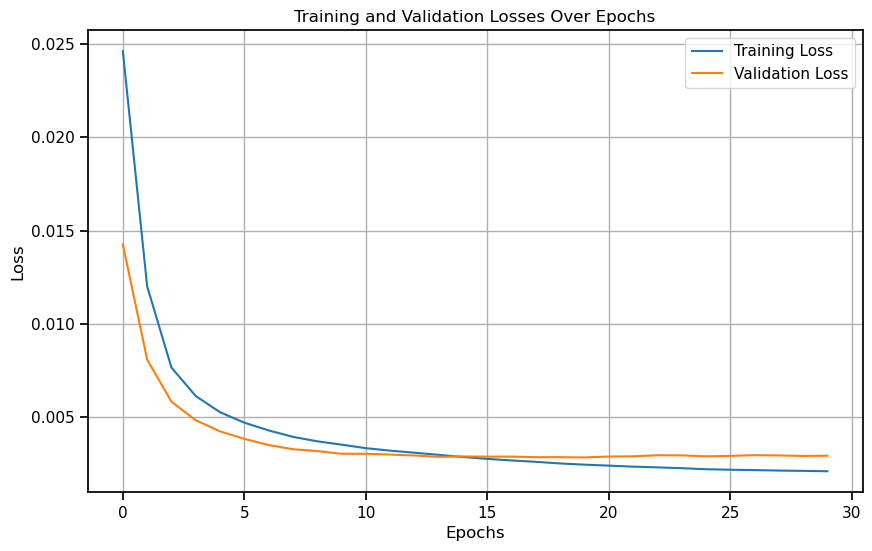

In [36]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [37]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Alldata'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_all, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [38]:
model_all_data = torch.load(path_to_save_model_fold)
model_all_data.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [39]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, model_all_data, metric = 'ev')

Train EV: 0.84 
Val EV: 0.73 
Test EV: 0.01 


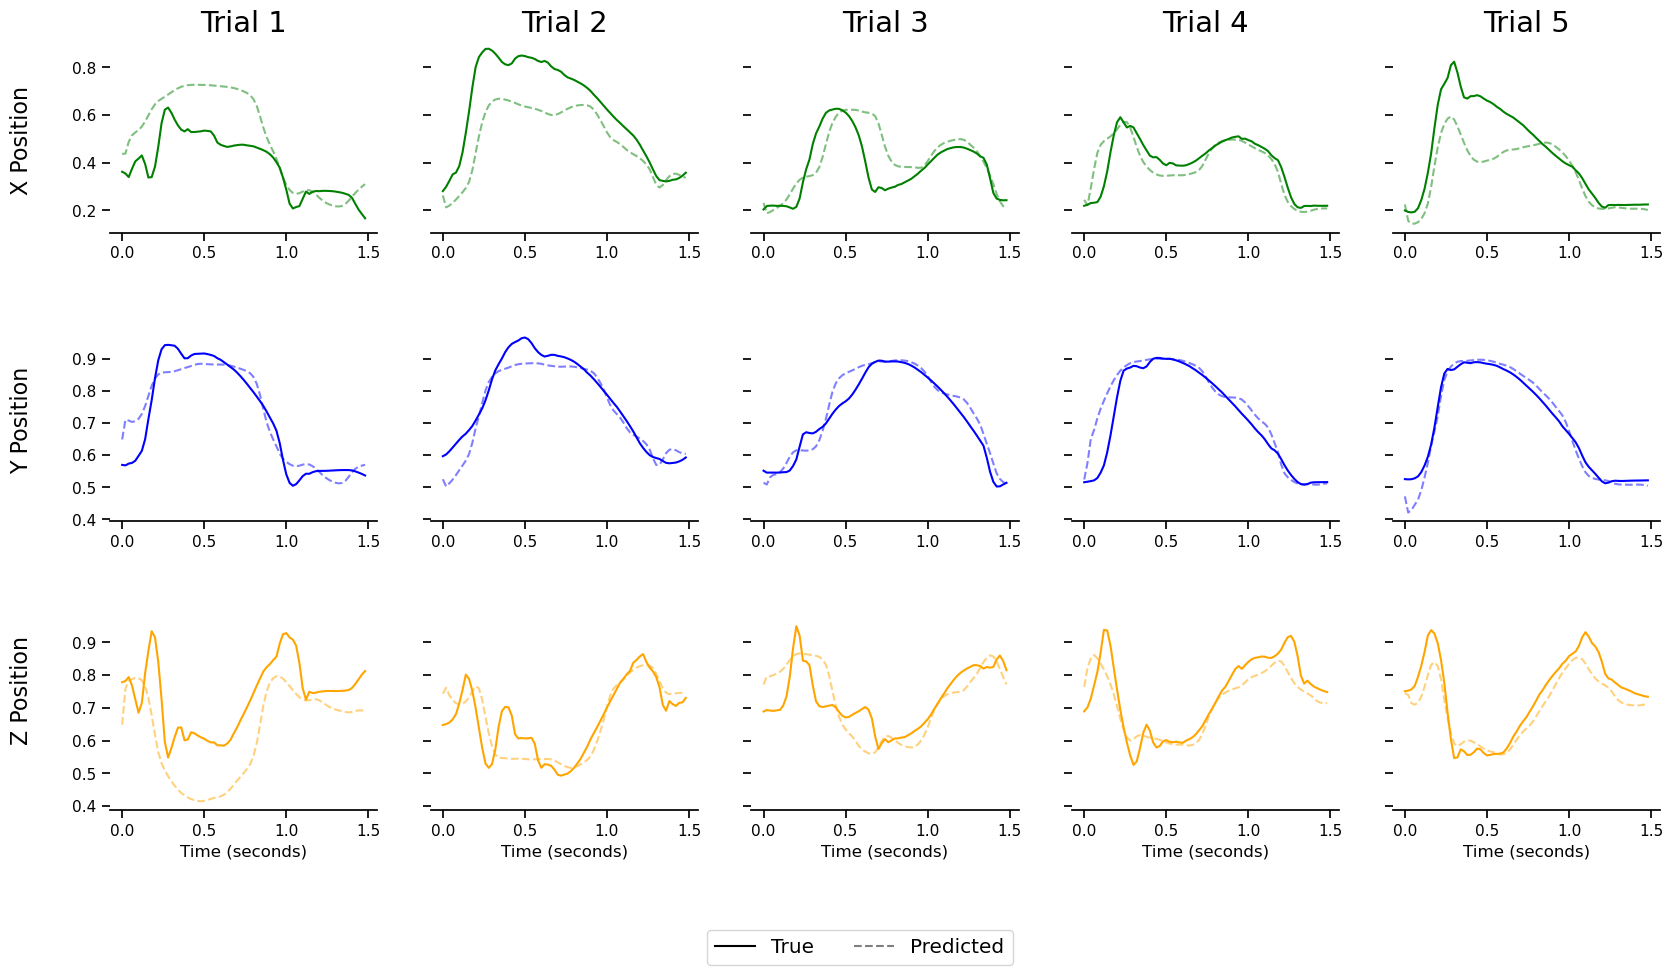

In [40]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Implementing EWC

In [41]:
def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        _loss = fisher[n] * (p - p_old[n]) ** 2
        loss += _loss.sum()
    return loss

In [42]:
x = to_t_eval(xx_train_base) 
y = to_t_eval(yy_train_base)

In [43]:
# Assuming X_train and y_train are NumPy arrays or PyTorch tensors
dataset = list(zip(x, y))

In [44]:
experiment_name_base = 'LSTM_2018'+date+'_Baseline'
path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))


In [45]:
model_baselineonly = torch.load(path_model_baseline)
model_baselineonly.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [46]:
params = {n: p for n, p in model_baselineonly.named_parameters() if p.requires_grad}
p_old = {}

for n, p in deepcopy(params).items():
    p_old[n] = p.data

In [47]:
def get_fisher_diag(model, dataset, params, empirical=True):
 
    fisher = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher[n] = p.data

    
    for input, gt_label in dataset:
        model.zero_grad()
        output = model(input).view(-1)
        if empirical:
            label = gt_label.view(-1)
            
        else:
            label = output.max(1)[1].view(-1)
            

        h_loss  = huber_loss(output, label)
        #negloglikelihood = F.nll_loss(F.log_softmax(output, dim = -1), label)
        #negloglikelihood.backward()
        model.train()
        h_loss.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [48]:
fisher_matrix = get_fisher_diag(model_baselineonly, dataset, params)

In [1]:
def train_model_EWC(model, X,Y,
                X_val, 
                Y_val,
                lr=lr, # 0.0001,
                lr_step_size= lr_step_size ,#10,
                lr_gamma=lr_gamma,#0.9,
                sequence_length_LSTM= seq_length_LSTM, #10,
                batch_size_train = batch_size_train, #3,
                batch_size_val = batch_size_val,# 3,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None,
                l1_ratio = l1_ratio_reg, #0.5,
                alpha = alpha_reg, #1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=sequence_length_LSTM)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=sequence_length_LSTM)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                X_ = X_.to(device)
                y_ = y_.to(device)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = huber_loss(output_t, y_, delta = delta)
                        
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            ewc_loss = get_ewc_loss(model, fisher_matrix, p_old)
                            loss_t += lambda_ewc * ewc_loss
                        #     loss += regularizer(model, l1_ratio, alpha)
                        # Compute gradients and perform an optimization step
                        loss_t.backward(retain_graph=True)
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = huber_loss(output_t, y_, delta = delta)
                    

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_epoch = epoch
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses), best_epoch

NameError: name 'lr' is not defined

In [50]:
train_losses, val_losses = \
    train_model_EWC(model_baselineonly, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= True,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 0.5
                )


Epoch 000 Train 0.0110 Val 0.0094
Epoch 001 Train 0.0091 Val 0.0086
Epoch 002 Train 0.0081 Val 0.0083
Epoch 003 Train 0.0075 Val 0.0080
Epoch 004 Train 0.0069 Val 0.0079
Epoch 005 Train 0.0066 Val 0.0077
Epoch 006 Train 0.0064 Val 0.0076
Epoch 007 Train 0.0061 Val 0.0076
Epoch 008 Train 0.0059 Val 0.0074
Epoch 009 Train 0.0057 Val 0.0074
Epoch 010 Train 0.0055 Val 0.0072
Epoch 011 Train 0.0053 Val 0.0072
Epoch 012 Train 0.0052 Val 0.0070
Epoch 013 Train 0.0051 Val 0.0071
Epoch 014 Train 0.0049 Val 0.0070
Epoch 015 Train 0.0048 Val 0.0070
Epoch 016 Train 0.0047 Val 0.0070
Epoch 017 Train 0.0046 Val 0.0070
Epoch 018 Train 0.0044 Val 0.0070
Epoch 019 Train 0.0044 Val 0.0070
Epoch 020 Train 0.0042 Val 0.0071
Epoch 021 Train 0.0041 Val 0.0071
Epoch 022 Train 0.0041 Val 0.0069
Epoch 023 Train 0.0040 Val 0.0067
Epoch 024 Train 0.0039 Val 0.0069
Epoch 025 Train 0.0038 Val 0.0068
Epoch 026 Train 0.0037 Val 0.0069
Epoch 027 Train 0.0037 Val 0.0067
Epoch 028 Train 0.0036 Val 0.0068
Epoch 029 Trai

In [51]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_EWC'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [52]:
model_EWC = torch.load(path_to_save_model_fold)
model_EWC.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

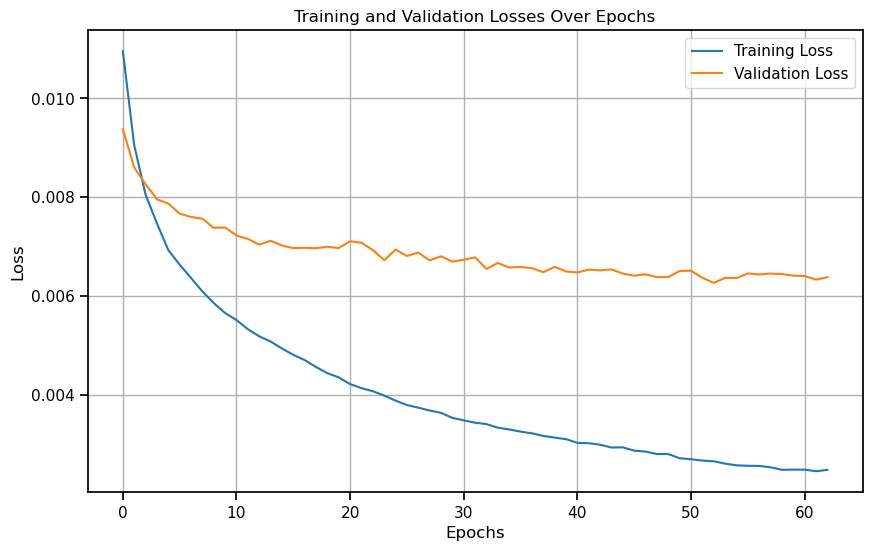

In [53]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [54]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_EWC, metric = 'ev')

Train EV: 0.92 
Val EV: 0.70 
Test EV: 0.01 


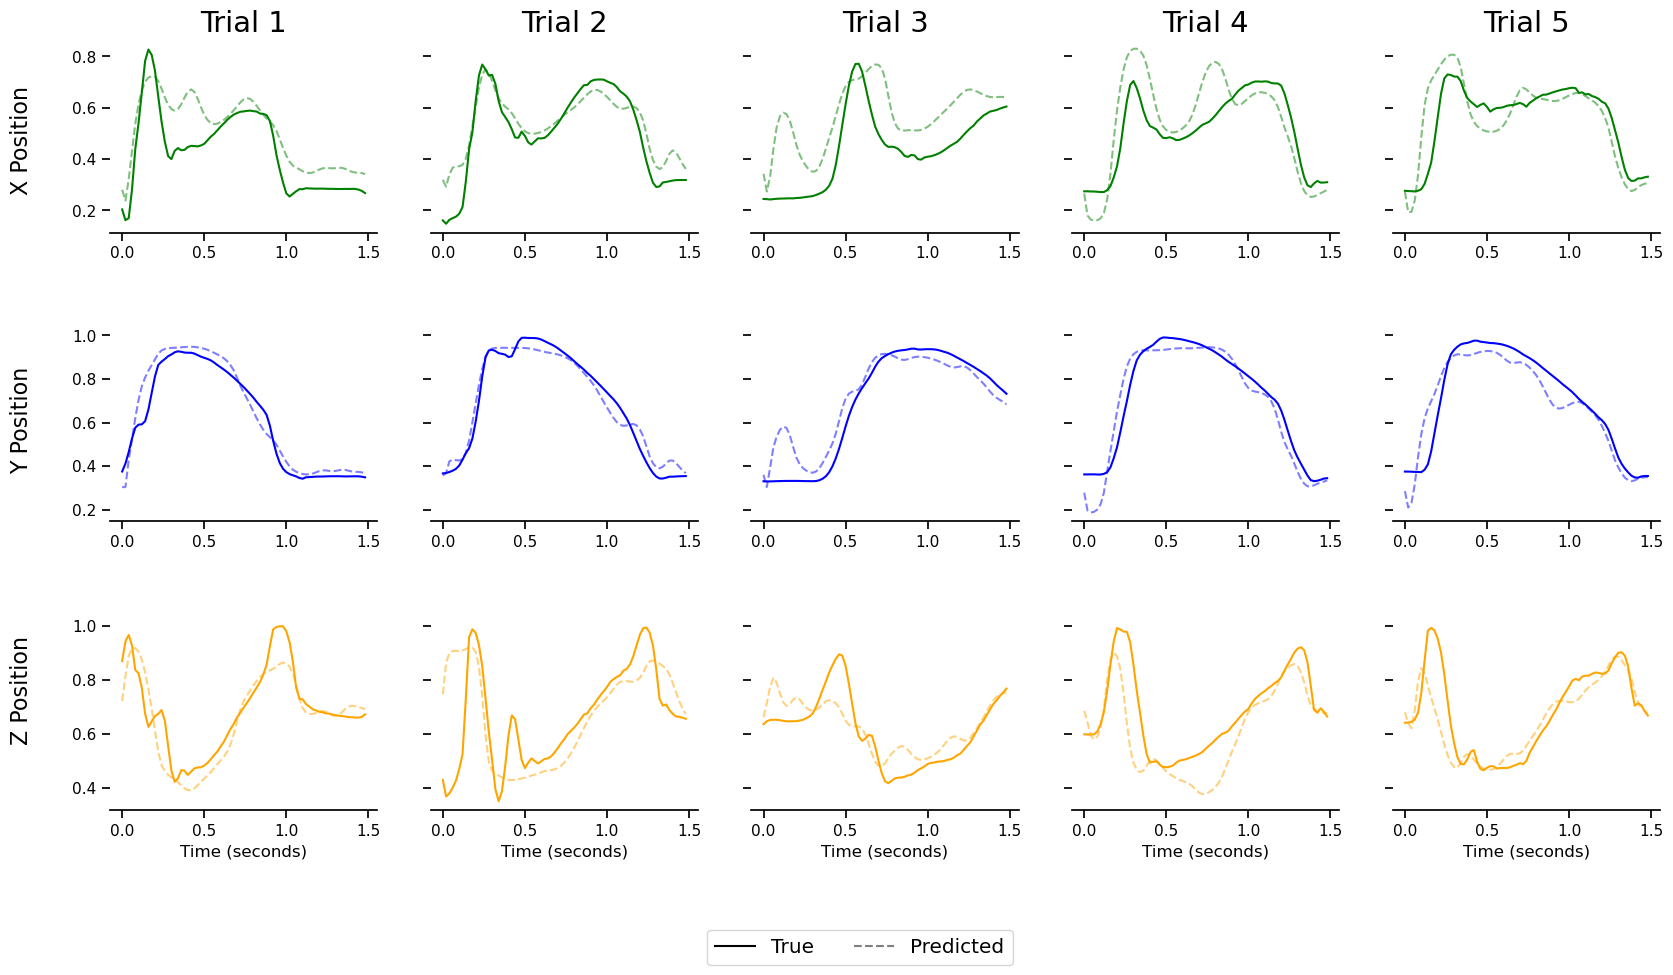

In [55]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Testing the performance of the model on Baseline data after EWC

In [56]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_EWC, metric = 'ev')

Train EV: 0.65 
Val EV: 0.63 
Test EV: 0.01 


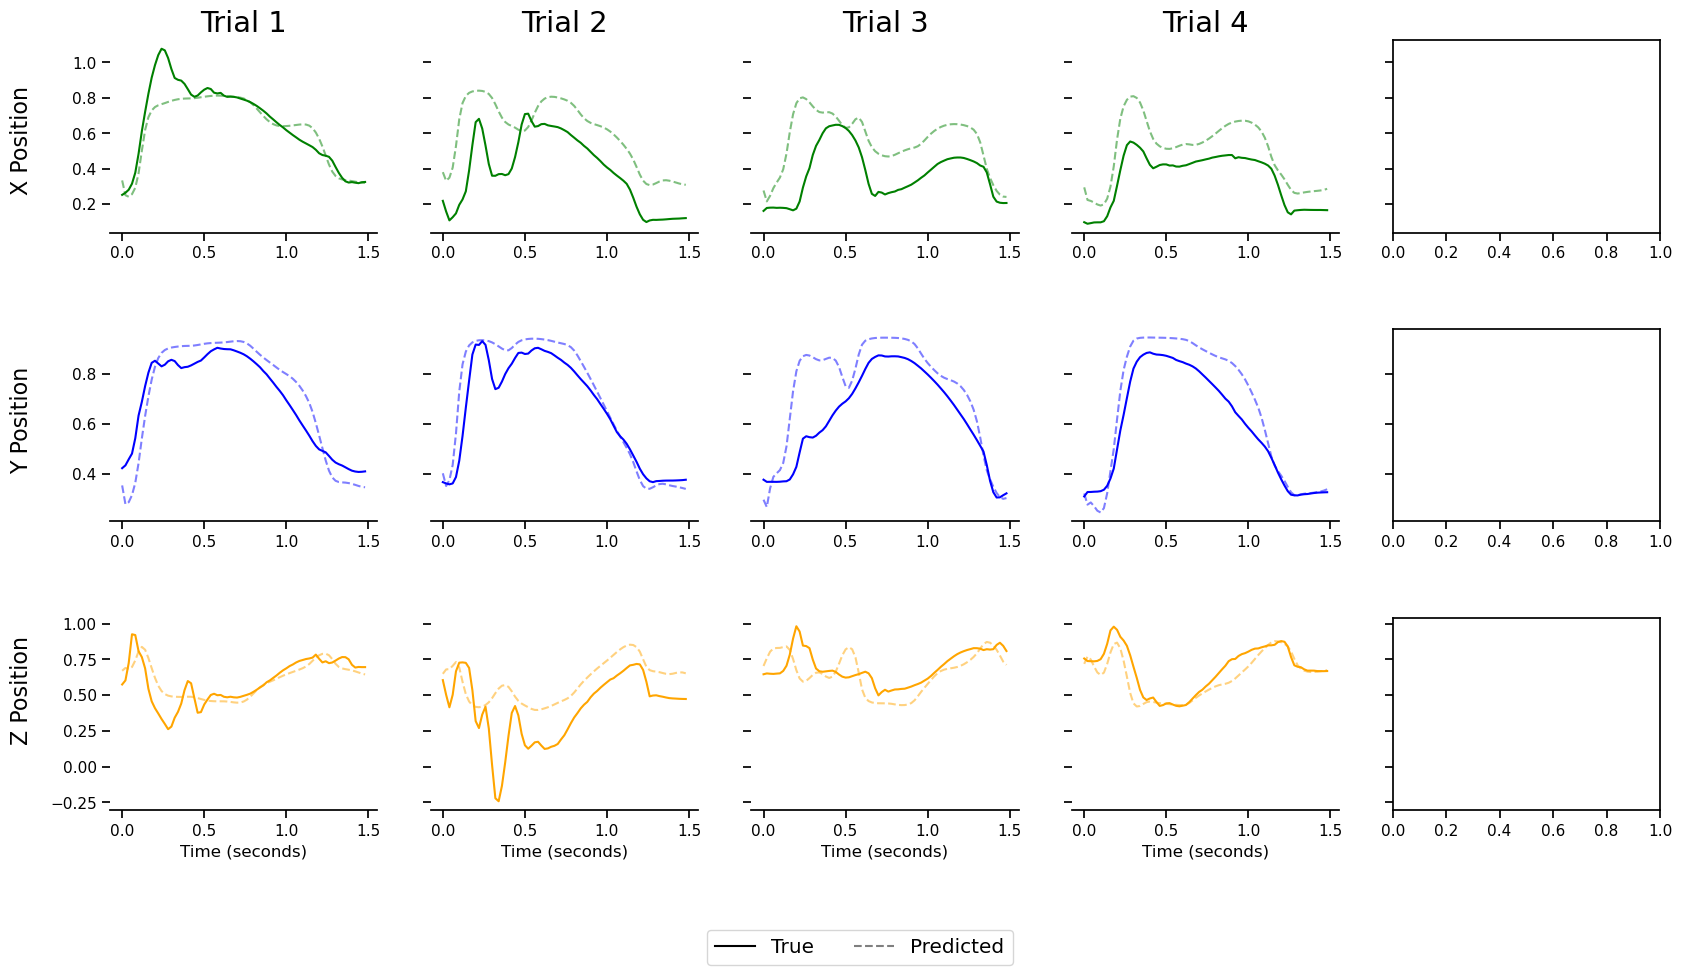

In [57]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Training model only on stimulation data and testing on baseline data

In [58]:
# Fit the LSTM model
model_stim = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_stim.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [59]:
train_losses, val_losses = \
    train_model(model_stim, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0309 Val 0.0282
Epoch 001 Train 0.0287 Val 0.0254
Epoch 002 Train 0.0237 Val 0.0195
Epoch 003 Train 0.0183 Val 0.0155
Epoch 004 Train 0.0147 Val 0.0129
Epoch 005 Train 0.0126 Val 0.0115
Epoch 006 Train 0.0113 Val 0.0107
Epoch 007 Train 0.0103 Val 0.0102
Epoch 008 Train 0.0094 Val 0.0098
Epoch 009 Train 0.0088 Val 0.0095
Epoch 010 Train 0.0083 Val 0.0093
Epoch 011 Train 0.0079 Val 0.0091
Epoch 012 Train 0.0076 Val 0.0088
Epoch 013 Train 0.0072 Val 0.0087
Epoch 014 Train 0.0070 Val 0.0086
Epoch 015 Train 0.0068 Val 0.0084
Epoch 016 Train 0.0065 Val 0.0083
Epoch 017 Train 0.0063 Val 0.0082
Epoch 018 Train 0.0061 Val 0.0080
Epoch 019 Train 0.0059 Val 0.0080
Epoch 020 Train 0.0058 Val 0.0078
Epoch 021 Train 0.0056 Val 0.0077
Epoch 022 Train 0.0055 Val 0.0076
Epoch 023 Train 0.0054 Val 0.0076
Epoch 024 Train 0.0052 Val 0.0074
Epoch 025 Train 0.0051 Val 0.0074
Epoch 026 Train 0.0050 Val 0.0074
Epoch 027 Train 0.0049 Val 0.0072
Epoch 028 Train 0.0048 Val 0.0072
Epoch 029 Trai

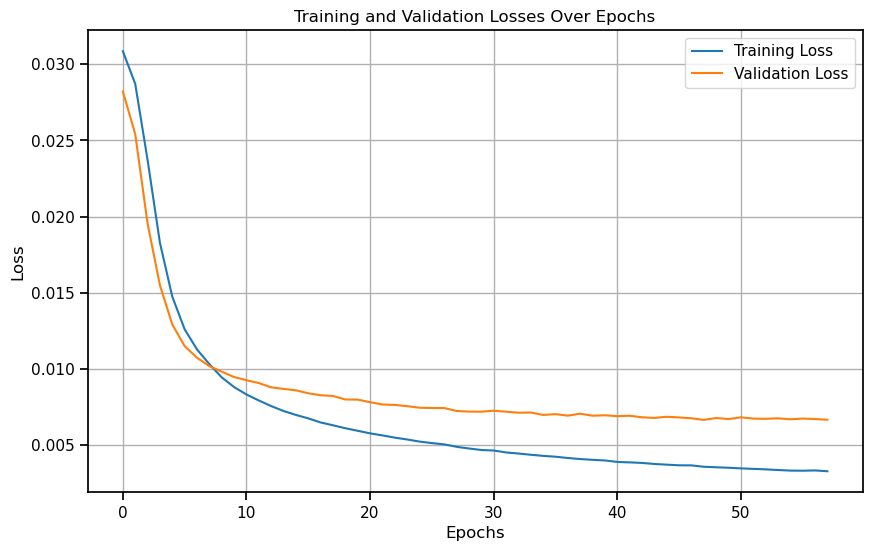

In [60]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [61]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stim, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)


In [62]:
model_stim = torch.load(path_to_save_model_fold)
model_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [63]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim, metric = 'ev')

Train EV: 0.87 
Val EV: 0.66 
Test EV: 0.01 


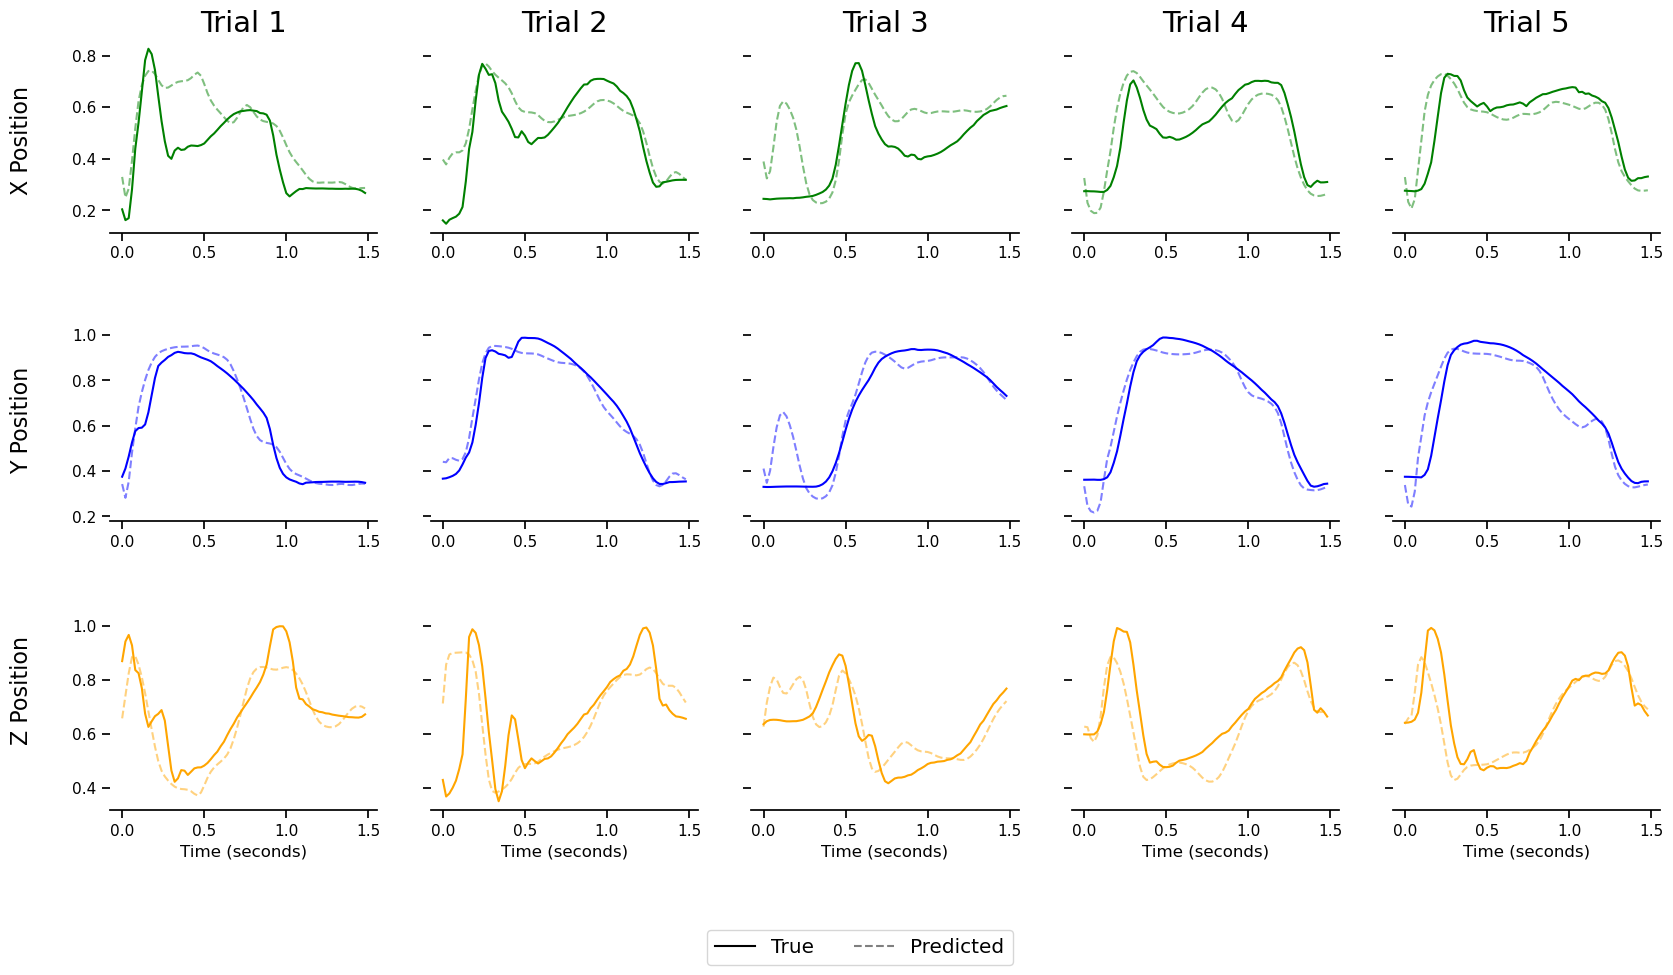

In [64]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Now test on baseline data to compare to the EWC

In [65]:
model_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [66]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim, metric = 'ev')

Train EV: 0.53 
Val EV: 0.50 
Test EV: 0.01 


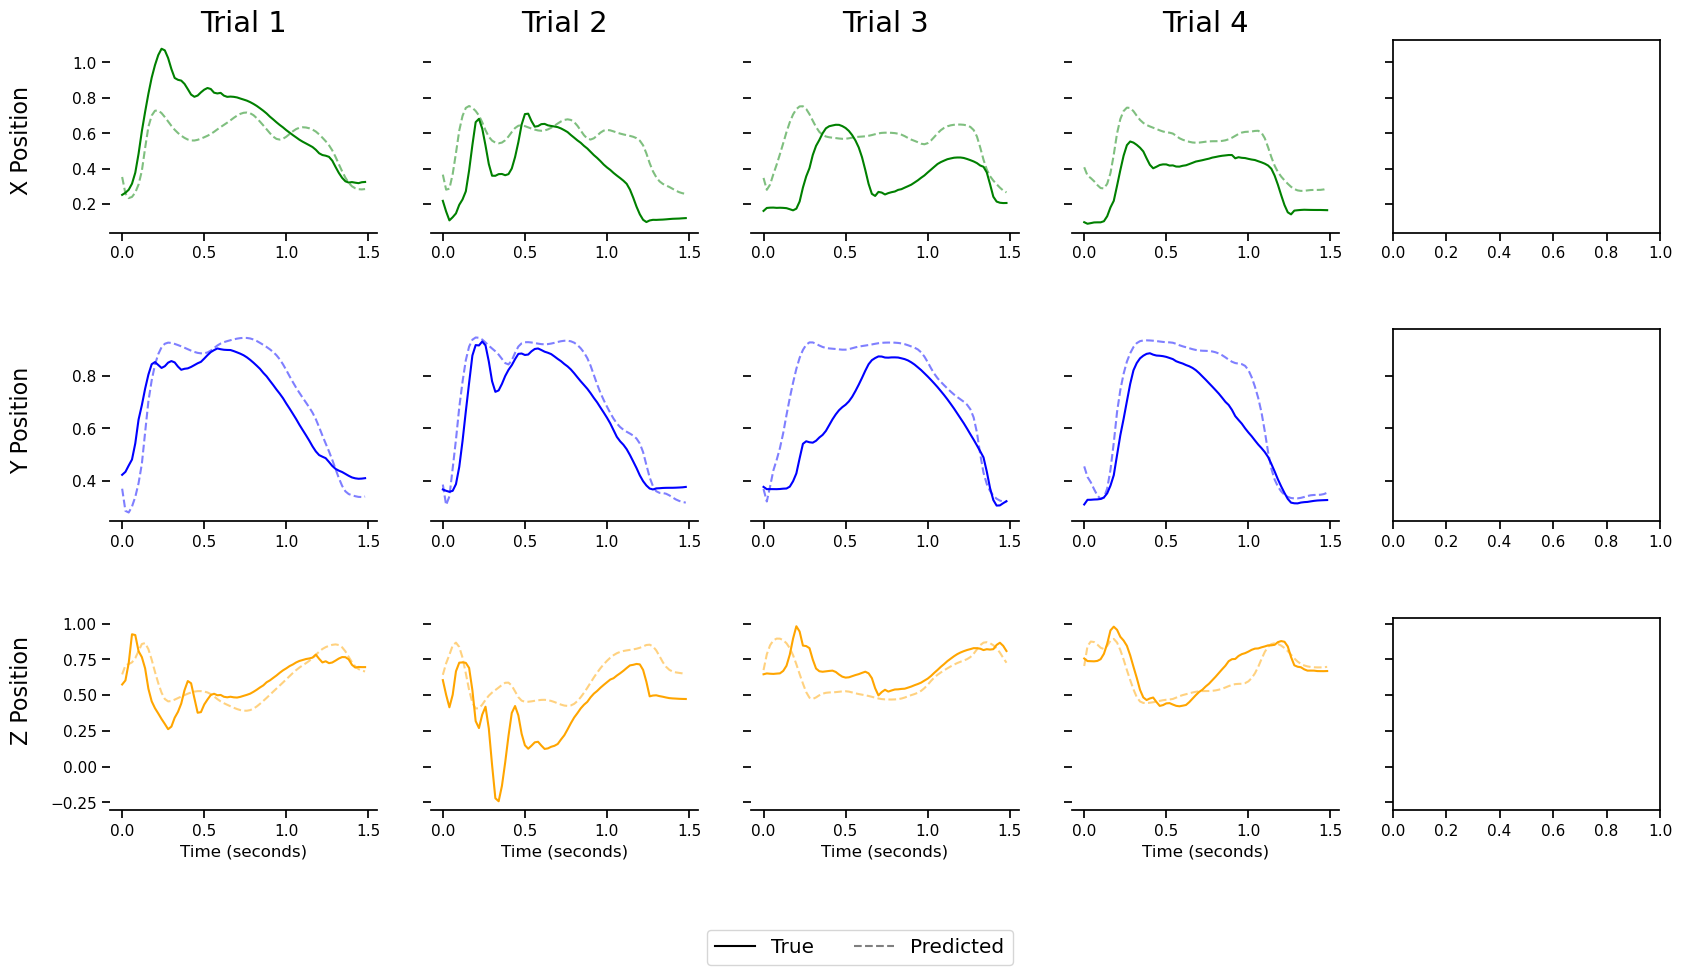

In [67]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Checking Catastrophic Forgetting

The idea here is to take models trained for one specific task, train them on the other task and then see how they generalize or not.

In [68]:
path_to_models = './Models'


In [69]:
experiment_name_base = 'LSTM_2018'+date+'_Baseline'
experiment_name_stim= 'LSTM_2018'+date+'_Stimulation'

In [70]:
path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))
path_model_stim = os.path.join(path_to_models, experiment_name_stim, 'fold_{}.pth'.format(fold))

In [71]:
model_baselineonly = torch.load(path_model_baseline)
model_baselineonly.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [72]:
model_stimonly = torch.load(path_model_stim)
model_stimonly.train()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

#### Training on stimulation data using baseline model

In [73]:
train_losses, val_losses = \
    train_model(model_baselineonly, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0110 Val 0.0093
Epoch 001 Train 0.0091 Val 0.0085
Epoch 002 Train 0.0081 Val 0.0082
Epoch 003 Train 0.0074 Val 0.0081
Epoch 004 Train 0.0070 Val 0.0079
Epoch 005 Train 0.0066 Val 0.0078
Epoch 006 Train 0.0063 Val 0.0076
Epoch 007 Train 0.0061 Val 0.0075
Epoch 008 Train 0.0059 Val 0.0075
Epoch 009 Train 0.0057 Val 0.0074
Epoch 010 Train 0.0055 Val 0.0072
Epoch 011 Train 0.0054 Val 0.0071
Epoch 012 Train 0.0052 Val 0.0072
Epoch 013 Train 0.0051 Val 0.0071
Epoch 014 Train 0.0050 Val 0.0072
Epoch 015 Train 0.0048 Val 0.0070
Epoch 016 Train 0.0047 Val 0.0069
Epoch 017 Train 0.0046 Val 0.0070
Epoch 018 Train 0.0045 Val 0.0069
Epoch 019 Train 0.0044 Val 0.0069
Epoch 020 Train 0.0042 Val 0.0069
Epoch 021 Train 0.0042 Val 0.0068
Epoch 022 Train 0.0041 Val 0.0069
Epoch 023 Train 0.0040 Val 0.0068
Epoch 024 Train 0.0039 Val 0.0069
Epoch 025 Train 0.0038 Val 0.0069
Epoch 026 Train 0.0037 Val 0.0070
Epoch 027 Train 0.0037 Val 0.0069
Epoch 028 Train 0.0036 Val 0.0067
Epoch 029 Trai

In [74]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation_after_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold)

In [75]:
model_stim_after_base = torch.load(path_to_save_model_fold)
model_stim_after_base.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [76]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim_after_base, metric = 'ev')

Train EV: 0.65 
Val EV: 0.63 
Test EV: 0.01 


In [77]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim_after_base, metric = 'ev')

Train EV: 0.91 
Val EV: 0.69 
Test EV: 0.01 


#### Training on baseline data using stimulation model

In [78]:
train_losses, val_losses = \
    train_model(model_stimonly, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0098 Val 0.0102
Epoch 001 Train 0.0080 Val 0.0090
Epoch 002 Train 0.0073 Val 0.0087
Epoch 003 Train 0.0069 Val 0.0085
Epoch 004 Train 0.0065 Val 0.0086
Epoch 005 Train 0.0063 Val 0.0085
Epoch 006 Train 0.0060 Val 0.0086
Epoch 007 Train 0.0057 Val 0.0085
Epoch 008 Train 0.0055 Val 0.0084
Epoch 009 Train 0.0054 Val 0.0084
Epoch 010 Train 0.0051 Val 0.0084
Epoch 011 Train 0.0051 Val 0.0084
Epoch 012 Train 0.0049 Val 0.0083
Epoch 013 Train 0.0048 Val 0.0083
Epoch 014 Train 0.0047 Val 0.0082
Epoch 015 Train 0.0046 Val 0.0082
Epoch 016 Train 0.0045 Val 0.0081
Epoch 017 Train 0.0044 Val 0.0081
Epoch 018 Train 0.0043 Val 0.0081
Epoch 019 Train 0.0043 Val 0.0079
Epoch 020 Train 0.0041 Val 0.0079
Epoch 021 Train 0.0041 Val 0.0079
Epoch 022 Train 0.0041 Val 0.0079
Epoch 023 Train 0.0040 Val 0.0078
Epoch 024 Train 0.0039 Val 0.0078
Epoch 025 Train 0.0039 Val 0.0078
Epoch 026 Train 0.0038 Val 0.0077
Epoch 027 Train 0.0038 Val 0.0077
Epoch 028 Train 0.0037 Val 0.0077
Epoch 029 Trai

In [79]:
path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline_after_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stimonly, path_to_save_model_fold)

In [80]:
model_base_after_stim = torch.load(path_to_save_model_fold)
model_base_after_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(31, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=128, out_features=31, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [81]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base_after_stim, metric = 'ev')

Train EV: 0.79 
Val EV: 0.57 
Test EV: 0.01 


In [82]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base_after_stim, metric = 'ev')

Train EV: 0.86 
Val EV: 0.66 
Test EV: 0.01 
